In [1]:
import torch as t
import pandas as pd
import numpy as np
import torch.nn as nn 
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torchvision import transforms as trf
from torch.utils.data import Dataset , DataLoader
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
import torch.nn.functional as F
import os 

c:\Users\SalmaneElFtouh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\SalmaneElFtouh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\SalmaneElFtouh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
print(t.cuda.is_available())
print(t.__version__)

if t.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = t.device(dev)  
print(device)
print(t.cuda.get_device_name(0))
print(t.cuda.get_device_properties(0))

True
1.13.0+cu117
cuda:0
NVIDIA GeForce RTX 2060
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2060', major=7, minor=5, total_memory=6143MB, multi_processor_count=30)


In [3]:
class CrowdDataSet(Dataset):
    def __init__(self, img_dir, label_dir, img_transforms=None, label_transforms=None):
        self.img_dir = os.path.join(img_dir, "images")
        self.label_dir = os.path.join(label_dir, "image_labels.txt")
        self.label_dir_hd_lvl = os.path.join(label_dir, "gt")
        self.img_transforms = img_transforms
        self.label_transforms = label_transforms
        self.db = pd.read_csv(self.label_dir)

    def __len__(self):
        return len(self.db)

    def add_rectangles(self,coord, img_size):
        output=t.zeros((1,img_size[1],img_size[2]),dtype=t.uint8)
        if coord is None: return output
        #print(img_size,output.shape)
            #print(output.shape,x,y,w,h)
        output_=draw_bounding_boxes(output,box_convert(t.tensor(coord.iloc[:,0:4].values),"xywh","xyxy"),fill=True)
        output[0,:,:]=output_[0,:,:]
        return output

    def verify_labels(self,labels:pd.DataFrame):
        for k in range(labels.shape[0]):
            l=labels.iloc[k,0:4]
            if any([e<0 for e in l]):
                return False
        return True
    def __getitem__(self, index):
        temp = str(self.db.iloc[index, 0])
        img_path = os.path.join(self.img_dir, ('0'*(4-len(temp)))+temp)+".jpg"
        labels_path = os.path.join(
            self.label_dir_hd_lvl, ('0'*(4-len(temp)))+temp)+".txt"
        #print(labels_path)
        label = t.tensor(self.db.iloc[index, 1], dtype=t.float)
        if label>0:
            try:
                head_labels = pd.read_csv(labels_path,header=None,sep=" ")
                valid_labels=self.verify_labels(head_labels)
                head_labels= head_labels if valid_labels else None
            except:
                head_labels=None
        else:
            head_labels=None
        
        
        
        image = read_image(img_path)
        result_mask = self.add_rectangles(head_labels, image.shape)
        if image.shape[0] == 1:
            image = image[0, :, :].repeat(3, 1, 1)
        """if result_mask.shape[0] == 1:
            result_mask = result_mask[0, :, :].repeat(3, 1, 1)"""

        
        
        if self.img_transforms:
            image = self.img_transforms(image)
            result_mask = self.img_transforms(result_mask)
        if self.label_transforms:
            label = self.label_transforms(label)
        return image/255, result_mask, label


In [4]:
labels_path = "../dataset/test/gt/0002.txt"
        

head_labels = pd.read_csv(labels_path,header=None,sep=" ")


In [5]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(e,device) for e in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device) -> None:
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [6]:
default_size=(256,256)

def resize(img,size):
    h,w=size
    c_h,c_w=img.shape[1],img.shape[2]
    if h<=-1 and w>-1:
        return trf.Resize(size=(int(w*c_h/c_w),w))(img)
    elif w<=-1 and h>-1:
        return trf.Resize(size=(h,int(h*c_w/c_h)))(img)
    elif w>-1 and h>-1:
        return trf.Resize(size=(h,w))(img)
    else:
        return img



def custom_pad(image,size=default_size):
    #print("image before :",image.shape)
    h,w=size
    c_h,c_w=image.shape[1],image.shape[2]
    if c_w>w:
        image=resize(image,(-1,w))
    c_h,c_w=image.shape[1],image.shape[2]
    if c_h>h:
        image=resize(image,(h,-1))
        
    c_h,c_w=image.shape[1],image.shape[2]
    if c_h<h:
        image= trf.Pad(padding=(0,np.abs(c_h-h)//2))(image)
    elif c_w<w:
        image= trf.Pad(padding=(np.abs(c_w-w)//2,0))(image)
    image=trf.Resize(size=(h,w))(image)
    #print("image after :",image.shape)
    return image

In [7]:
bs=1
dirs={x:os.path.join('../dataset',x) for x in ['test','train','val']}
#data_set={x:CrowdDataSet(dirs[x],dirs[x],trf.Lambda(custom_pad)) for x in dirs}
data_set={x:CrowdDataSet(dirs[x],dirs[x],trf.Lambda(custom_pad)) for x in dirs}
data_loader_={x:DataLoader(data_set[x],bs,shuffle=False) for x in dirs}
data_loader={x:DeviceDataLoader(data_loader_[x],device) for x in dirs}

In [8]:
image,mask_,label=next(iter(data_loader_['test']))


torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
tensor([59.])


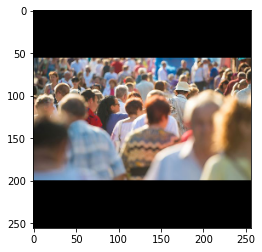

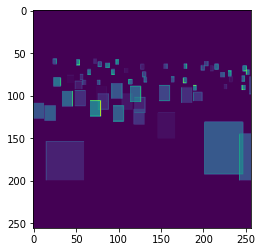

In [9]:
print(image.shape)
print(mask_.shape)
print(label)
i=0
plt.figure(1)
plt.imshow(image[i].permute(1,2,0).cpu())
plt.figure(2)
plt.imshow(mask_[i].permute(1,2,0).cpu())




In [10]:
if False: 
    from model import UNet
    from train import train
    #model=UNet(3,1).to(device)
    model=t.load("unet_crowd_counting.mdl").to(device)
    def criterion(output,target):
        return t.mean((output-target)**2)

    def accuracy(output,target):
        intersection=t.where((output!=0) & (target!=0),1,0).detach().cpu()
        union=t.where((output!=0) | (target!=0),1,0).detach().cpu()
        return intersection.sum()/union.sum()

    nbepochs=10
    t.cuda.empty_cache()
    train(model,criterion,accuracy,data_loader['train'],nbepochs,device)

In [13]:
from model import WNet
from train import train_Wnet

model=WNet(3,1).to(device)
#model=t.load("wnet_crowd_counting.mdl").to(device)
def criterion1(output,target):
  return t.mean((output-target)**2)

def criterion2(output,target):
  return t.abs(output-target)

def accuracy1(output,target):
    intersection=t.where((output!=0) & (target!=0),1,0).detach().cpu()
    union=t.where((output!=0) | (target!=0),1,0).detach().cpu()
    
    return intersection.sum()/union.sum()

def accuracy2(output,label):
    allowed_var=t.pow(label.data.cpu()*0.2,2)
    allowed_var=t.where(allowed_var==0,t.ones(allowed_var.shape)*5,allowed_var)
    acc = t.mean(t.exp(-t.pow(output.cpu() - label.data.cpu(),2)/allowed_var))
    if acc.isnan():
        print(f"{acc} is nan")
        return 0.
    return acc

nbepochs=10
t.cuda.empty_cache()
train_Wnet(model,criterion1,criterion2,accuracy1,accuracy2,data_loader['train'],nbepochs,device,lr=0.01)

c:\Users\SalmaneElFtouh\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 0


100%|██████████| 2271/2271 [20:26<00:00,  1.85it/s] 


epoch loss [seg,counting] :  196.5544
epoch acc [seg,counting] :  0.08745433
Epoch 1


100%|██████████| 2271/2271 [16:42<00:00,  2.26it/s]


epoch loss [seg,counting] :  192.37547
epoch acc [seg,counting] :  0.08745433
Epoch 2


100%|██████████| 2271/2271 [17:46<00:00,  2.13it/s]


epoch loss [seg,counting] :  189.24557
epoch acc [seg,counting] :  0.087454334
Epoch 3


100%|██████████| 2271/2271 [17:51<00:00,  2.12it/s]


epoch loss [seg,counting] :  183.99901
epoch acc [seg,counting] :  0.087454334
Epoch 4


100%|██████████| 2271/2271 [17:49<00:00,  2.12it/s]


epoch loss [seg,counting] :  181.56537
epoch acc [seg,counting] :  0.087454334
Epoch 5


100%|██████████| 2271/2271 [17:34<00:00,  2.15it/s]


epoch loss [seg,counting] :  180.70175
epoch acc [seg,counting] :  0.08745433
Epoch 6


100%|██████████| 2271/2271 [17:47<00:00,  2.13it/s]


epoch loss [seg,counting] :  179.09671
epoch acc [seg,counting] :  0.08745433
Epoch 7


100%|██████████| 2271/2271 [17:43<00:00,  2.14it/s]


epoch loss [seg,counting] :  177.69052
epoch acc [seg,counting] :  0.08745433
Epoch 8


100%|██████████| 2271/2271 [17:56<00:00,  2.11it/s]


epoch loss [seg,counting] :  176.92732
epoch acc [seg,counting] :  0.087454334
Epoch 9


100%|██████████| 2271/2271 [17:58<00:00,  2.11it/s]


epoch loss [seg,counting] :  175.68562
epoch acc [seg,counting] :  0.08745432


In [22]:
image,mask_,label=next(iter(data_loader['test']))
output,x=model(image)
output=output.cpu().detach()
x=x.cpu().detach()

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
tensor([59.], device='cuda:0')
tensor([[0.]])


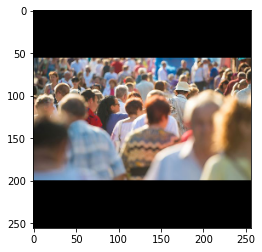

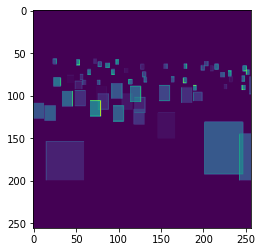

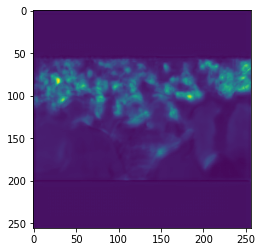

In [24]:
print(image.shape)
print(mask_.shape)
print(output.shape)
print(label,x)
i=0
plt.figure(1)
plt.imshow(image[i].permute(1,2,0).cpu())
plt.figure(2)
plt.imshow(mask_[i].permute(1,2,0).cpu())
plt.figure(3)
plt.imshow(output[i].permute(1,2,0).cpu())